# Effective feature engineering

Say, you have a model which takes 1 hour to train. Do you always need to wait for 1 hour to see the impact of a newly added feature?

I talked with experienced Kaggers about feature engineering.
They said that you get more accurate result when you check on the actual complex model you carefully built. But, it can be another risk if longer training time reduces the number of your trials.

**Traid-off: Accurate result <=> The number of trials**

How they work on a competition is like below.

1. EDA
2. Build a simple model
3. Try various features on a simple model
4. Build a complex model
5. Train with promising features

They go back and forth between steps during a competition. If you successfully setup an effective environment for experiments at the beginning of the competition, it puts you at an advantage.

I created a Kernel dedicated for feature engineering for this competition. I'd like to share what I've done so far.

1. Correlation
2. Score gain on a simple model
3. Feature importances of Tree models
4. Permutation importance
5. SHAP values
6. Score gain on a complex model

The upper things are faster but less accurate and lower things are more accurate but slower. I'm trying from the top of the list when I come up with a new idea.

## 1. Correlation

This is the simplest way to see the relation between features. In here, if the value on the target is close to 0, it means that the feature may be irrelevant to the target.

In [1]:
cd d:\HKUST\Machine Learning\Project\data

d:\HKUST\Machine Learning\Project\data


In [2]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reload():
    gc.collect()
    df = pd.read_csv('train_V2.csv')
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df

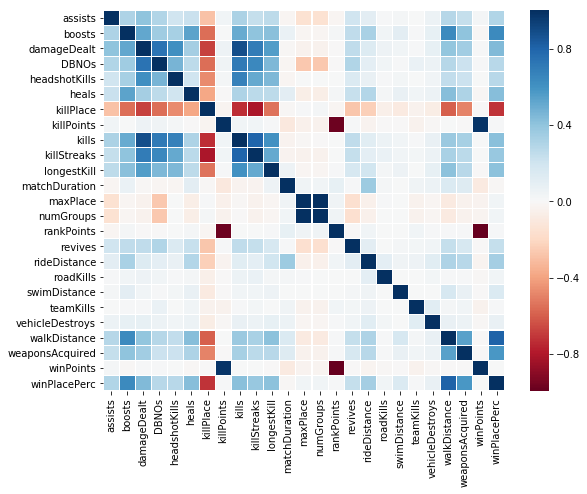

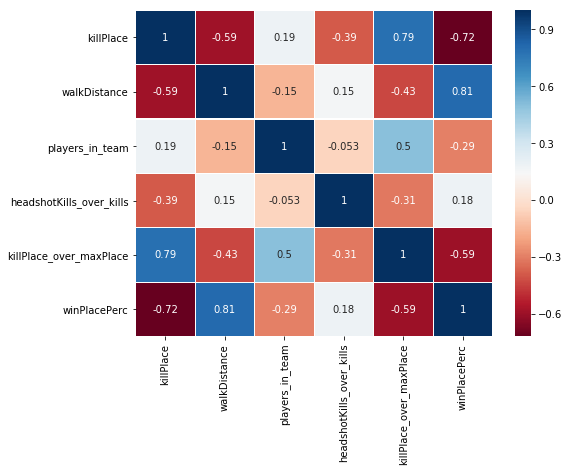

In [3]:
df = reload()

cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

Checking correlation is the fastest way to estimate the impact but it doesn't capture the actual contribution of the score. I will show an example in another Kernel.

## 2. Score gain on a simple model

I used LinearRegression during feature engineering since it's simple and fast. It'd be enough if you just want to see the impact of the new feature you added.

Aside from the main topic of this Kernel, it's better to split dataset by match since **we predict results by group in match**.

In [4]:
def train_test_split(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

`run_experiments` method takes preprocess functions and returns DataFrame.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):
    df = reload()
    df.drop(columns=['matchType'], inplace=True)
    
    df = preprocess(df)

    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train, val = train_test_split(df, 0.1)
    
    model = LinearRegression()
    model.fit(train[cols_to_fit], train[target])
    
    y_true = val[target]
    y_pred = model.predict(val[cols_to_fit])
    return mean_absolute_error(y_true, y_pred)

def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time() - start
        results.append({
            'name': preprocess.__name__,
            'score': score,
            'execution time': '{}s'.format(round(execution_time, 2))
        })
        gc.collect()
        
    return pd.DataFrame(results, columns=['name', 'score', 'execution time']).sort_values(by='score')

Let's see player-level generated features.

In [6]:
def original(df):
    return df

def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

In [10]:
run_experiments([
#     original,
    items
#     players_in_team,
#     total_distance,
#     headshotKills_over_kills,
#     killPlace_over_maxPlace,
#     walkDistance_over_heals,
#     walkDistance_over_kills,
#     teamwork
])

,name,score,execution time
0,items,0.092974,59.42s


We can see the score and the execution time.

Next, let's see aggregated features.

In [8]:
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

In [14]:
run_experiments([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

,name,score,execution time
6,rank_by_team,0.057774,56.49s
4,median_by_team,0.075883,49.03s
5,mean_by_team,0.077083,47.63s
2,max_by_team,0.078436,48.35s
3,sum_by_team,0.088642,48.55s
1,min_by_team,0.089845,47.63s
0,original,0.092959,25.88s


You can see how important rank features are in this competition.

## 3. Feature importances of Tree models

Tree models can output feature importances.

[20]	valid_0's l1: 0.065791
[40]	valid_0's l1: 0.0621489
[60]	valid_0's l1: 0.0609138
[80]	valid_0's l1: 0.0602587
[100]	valid_0's l1: 0.059752


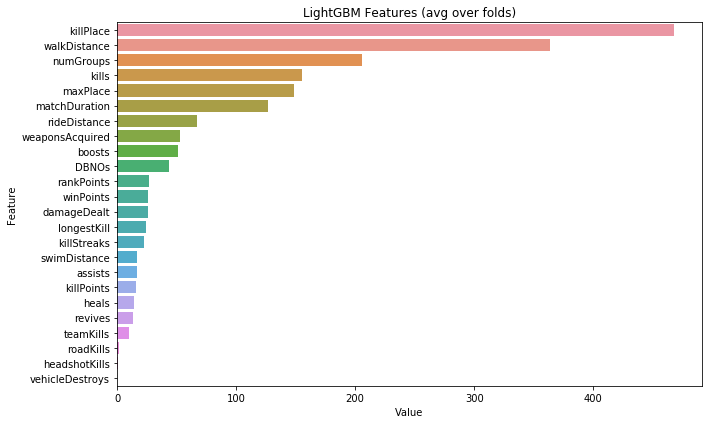

In [15]:
df = reload()

# Option 1: Give it as category
# df['matchType'] = df['matchType'].astype('category')
# Option 2: pd.dummies
# df = pd.concat([df, pd.get_dummies(df['matchType'])], axis=1)
# Option 3: Drop it for now (Not the best solution)
df.drop(columns=['matchType'], inplace=True)

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)

from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

There are several options for measuring importance like "split" (How many times the feature is used to split), "gain" (The average training loss reduction gained when using a feature for splitting).

However, sometimes it doesn't represent the actual contribution.

<img src="https://cdn-images-1.medium.com/max/1600/1*UEQiHKTnjHJ-swIjcAkRnA.png" width="640">

> To our dismay we see that the feature importance orderings are very different for each of the three options provided by XGBoost! For the cover method it seems like the capital gain feature is most predictive of income, while for the gain method the relationship status feature dominates all the others. This should make us very uncomfortable about relying on these measures for reporting feature importance without knowing which method is best.

<div align="center">
    <a href="https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27">Interpretable Machine Learning with XGBoost</a>
</div>

This is the background of Interpretable machine learning which is a field receiving a lot of attention recently. You can find papers and libraries here: [lopusz/awesome-interpretable-machine-learning](https://github.com/lopusz/awesome-interpretable-machine-learning)

## 4. Permutation importance

The basic idea is that observing how much the score decreases when a feature is not available; the method is known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

In [16]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(val[cols_to_fit], val[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

ImportError: No module named 'eli5'

The figure shows the importance of each feature. ELI5 shuffles the target feature instead of removing it to make it useless so that we don't need to re-train the model again. That's why it's represented like `± 0.0033` (standard deviation).

Removing a feature and see the difference... this is what I was doing above, but more reliable! However, there is room to discuss how to define/measure contribution.

## 5. SHAP values

SHAP proposed a new fair way to measure contribution which is justified in game theory.

[A Unified Approach to Interpreting Model
Predictions](https://arxiv.org/pdf/1705.07874.pdf) (2017)

> Understanding why a model makes a certain prediction can be as crucial as the prediction’s accuracy in many applications. However, the highest accuracy for large modern datasets is often achieved by complex models that even experts struggle to interpret, such as ensemble or deep learning models, creating a tension between accuracy and interpretability.

Simple models are easy to interpret. They built a simple model which works well only on a local point (We don't need to predict on the all points). Then, use the simple model to interpret how it's trained.

<img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png" width="420">

This method was proposed in this paper: [“Why Should I Trust You?”
Explaining the Predictions of Any Classifier](https://arxiv.org/pdf/1602.04938.pdf) (2016, known as LIME)

The main contribution of SHAP is that they introduced the concept of Shapley Value to measure the contribution.

Shapley Value is a solution concept in cooperative game theory, proposed in 1953 by [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley).

- Question: What is a "fair" way for a colition to divide its payoff?
  - Depends on the definition of "fairness"
- Approach: Identify axioms that express properties of a fair payoff division
  - Symmetry: Interchangeable agents should receive the same payments
  - Dummy Players: Dummy players should receive nothing
  - Additivity: $$(v_1 + v_2)(S) = v_1(S) + v_2(S)$$

The author of SHAP found that we can apply this concept to machine learning. In machine learning, *player* is *feature*, and *contribution* is *score*.

For example, we have 3 features L, M, and N. The shapley values are calculated like below.

<img src="https://cdn-images-1.medium.com/max/1600/1*DLL5sCQKeVXboAYIvdgwUw.png" width="640">
<img src="https://cdn-images-1.medium.com/max/1600/1*uGjQRe9U0ebC5HxYXAzg3A.png" width="420">

It's the average of combinations of features. Intuitively, it sounds fair.

The implementation is available on GitHub: [slundberg/shap: A unified approach to explain the output of any machine learning model](https://github.com/slundberg/shap)

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val[cols_to_fit])

SHAP values represent the fair score of features depending on their contribution towards the total score in the set of features.

In [ ]:
shap.summary_plot(shap_values, val[cols_to_fit], plot_type='bar')

SHAP also can visualize how the score changes when the feature value is low/high on each data.

In [ ]:
shap.summary_plot(shap_values, val[cols_to_fit], feature_names=cols_to_fit)

## 6. Score gain on a complex model

Checking on the real model. After selecting important features, I start looking at the actual impact on a complex model.

---

So, what should we do? It depends on the requirement and there is a trade-off but I'd recommend to build an environment to try new ideas quickly and fail quickly! You'd earn new ideas through the process.

Thank you for reading this Kernel. I'm still new to this field. I'd like to hear how you work on feature engineering.